In [1]:
import DataPreprocessor as dp
import numpy as np
import pandas as pd
import torch

from models import Sklearn_Classifier, ACNN, train_test
from sklearn.ensemble import RandomForestClassifier

import importlib
importlib.reload(dp)

# Örnek kullanım:
interval = '1h'
start_date = "01 Jan, 2020"
end_date = "10 Jul, 2024"
X_df, y = dp.get_historical_data(interval, start_date, end_date) # problem, X is df but y is np
feature_names = X_df.columns.tolist()
X = X_df.to_numpy()
print(X.shape)
print(y.shape)

# Train Test Split
train_size = 0.8
train_sample_size = int(X.shape[0]*train_size)
X_train = X[:train_sample_size, :]
y_train = y[:train_sample_size]
X_test = X[train_sample_size:, :]
y_test = y[train_sample_size:]
print(f"Training Matrix: {X_train.shape}")
print(f"Training labels: {y_train.shape}")
print(f"Test Matrix: {X_test.shape}")
print(f"Test labels {y_test.shape}")

(39565, 20)
(39565,)
Training Matrix: (31652, 20)
Training labels: (31652,)
Test Matrix: (7913, 20)
Test labels (7913,)


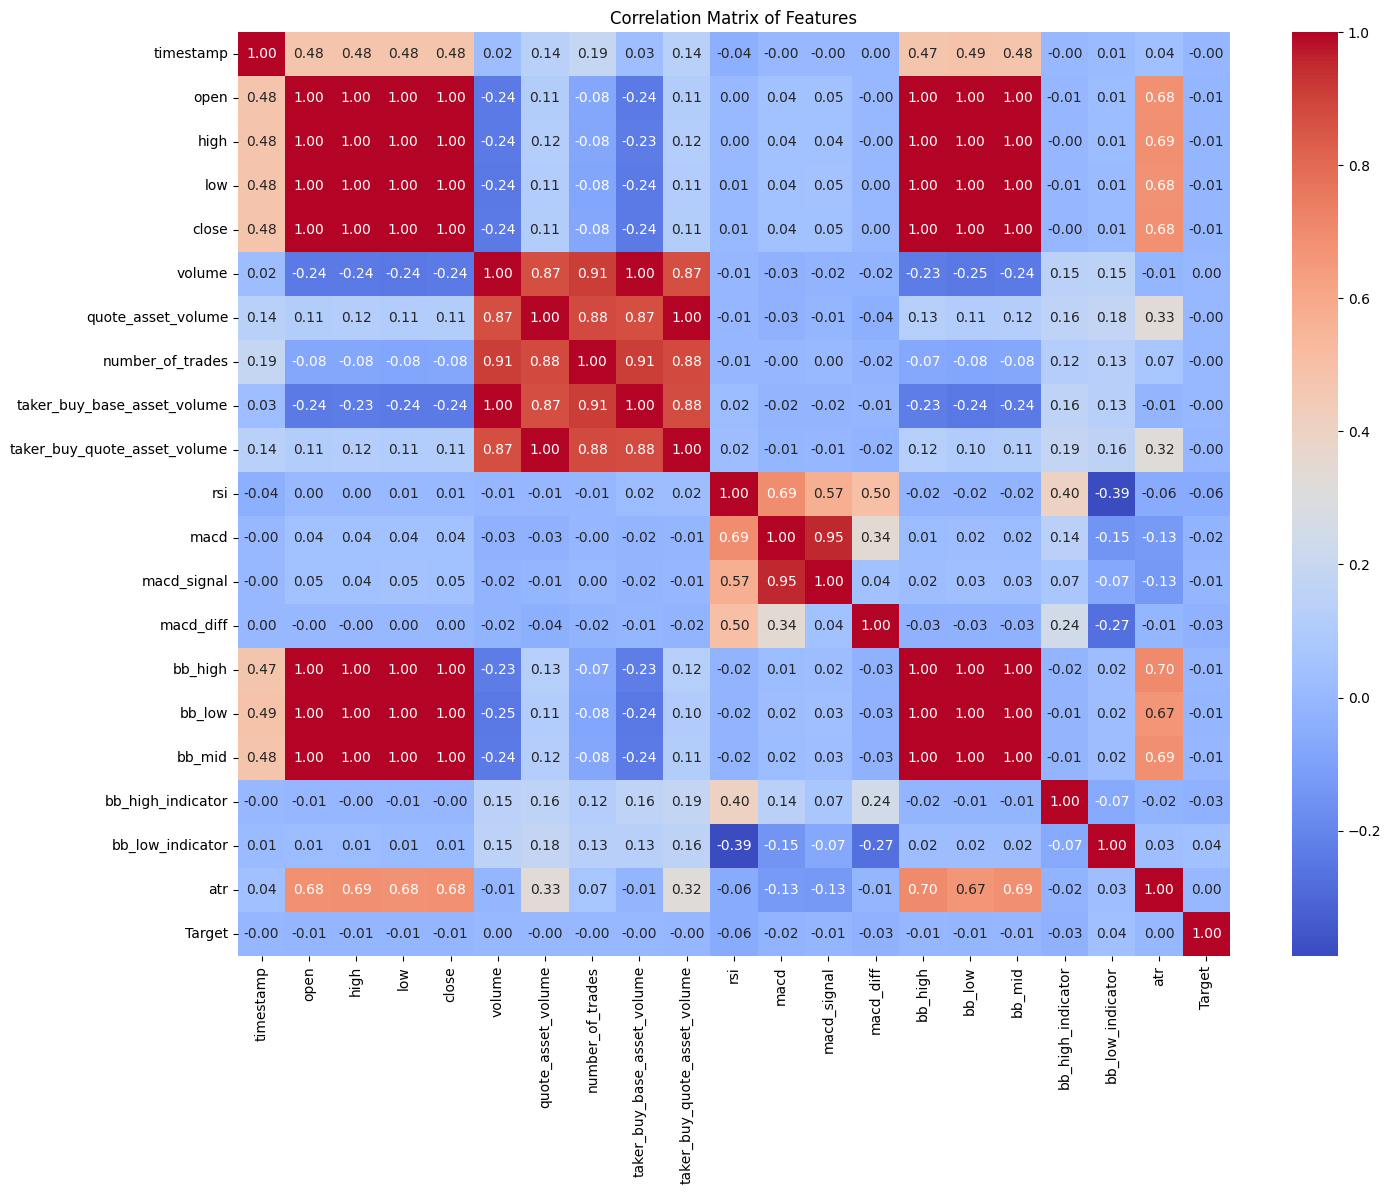

Correlation Matrix:
                              timestamp      open      high       low  \
timestamp                      1.000000  0.482067  0.480068  0.484308   
open                           0.482067  1.000000  0.999939  0.999911   
high                           0.480068  0.999939  1.000000  0.999859   
low                            0.484308  0.999911  0.999859  1.000000   
close                          0.482067  0.999895  0.999939  0.999930   
volume                         0.023073 -0.240345 -0.237714 -0.243864   
quote_asset_volume             0.135431  0.114747  0.118716  0.109204   
number_of_trades               0.191014 -0.077617 -0.075351 -0.080802   
taker_buy_base_asset_volume    0.026986 -0.237561 -0.234698 -0.240710   
taker_buy_quote_asset_volume   0.137475  0.113353  0.117696  0.108398   
rsi                           -0.040062  0.002797  0.004682  0.006238   
macd                          -0.000614  0.041963  0.041361  0.044095   
macd_signal                   -

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# y'nin dağılımını çizme
def plot_y_distribution(y):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=y)
    plt.title("Distribution of Target Variable (y)")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

def plot_and_save_correlation_matrix(x):
    plt.figure(figsize=(16, 12))
    corr_matrix = x.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix of Features")
    plt.show()
    
    # Korelasyon matrisini yazdırma
    print("Correlation Matrix:")
    print(corr_matrix)
    
    # Korelasyon matrisini dosyaya kaydetme
    with open('correlation_matrix.txt', 'w') as f:
        f.write(corr_matrix.to_string())

def plot_and_print_correlation_matrix(x):
    plt.figure(figsize=(16, 12))
    corr_matrix = x.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix of Features")
    plt.show()
    
    # Korelasyon matrisini yazdırma
    print("Correlation Matrix:")
    print(corr_matrix)

# y'nin dağılımını çiz
#plot_y_distribution(y)

# x'in korelasyon matrisini çiz
plot_and_print_correlation_matrix(X_df)


In [4]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
import numpy as np

k = 12  # Seçmek istediğiniz en iyi özellik sayısı
selector = SelectKBest(score_func=f_classif, k=k)  
#estimator = RandomForestClassifier()
#selector = RFE(estimator, n_features_to_select=k, step=1)

# Model pipeline oluşturma
pipeline = Pipeline([
    ('feature_selection', selector),
    ('classification', RandomForestClassifier(criterion="log_loss", class_weight="balanced_subsample", max_depth=10, n_estimators=500, min_samples_split=4))
])

# Modeli eğitmef
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Model performansını değerlendirme
from sklearn.metrics import accuracy_score, classification_report
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}")

selected_features = selector.get_support(indices=True)
selected_feature_names = [feature_names[i] for i in selected_features]
print("Selected Features:", selected_feature_names)


Accuracy: 0.5219259446480475
Classification Report: 
              precision    recall  f1-score   support

           0       0.51      0.70      0.59      3859
           1       0.55      0.35      0.43      4054

    accuracy                           0.52      7913
   macro avg       0.53      0.53      0.51      7913
weighted avg       0.53      0.52      0.51      7913

Selected Features: ['open', 'high', 'low', 'close', 'rsi', 'macd', 'macd_diff', 'bb_low', 'bb_mid', 'bb_high_indicator', 'bb_low_indicator']


F1-score macro: 0.5366250933810627
Accuracy: 0.536625321787971


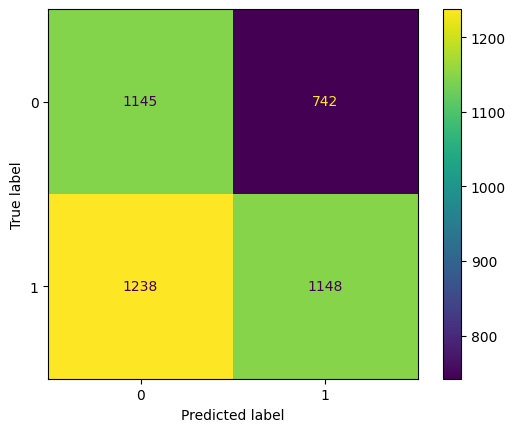

In [129]:
model = Sklearn_Classifier(sklearn_classifier=RandomForestClassifier(criterion="log_loss", class_weight="balanced_subsample", max_depth=10, n_estimators=500, min_samples_split=4))
model.train_test(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test) 

: 

In [4]:
X_train = torch.from_numpy(X_train.astype('float64')).unsqueeze_(2)
X_test = torch.from_numpy(X_test.astype('float64')).unsqueeze_(2)
print(X_train.shape)
print(X_test.shape)

torch.Size([31652, 21, 1])
torch.Size([7913, 21, 1])


In [5]:
model = ACNN(in_channels=20, out_channels=1, att_channels=1, n_len_seg=1, n_classes=2)
trn_ds = torch.utils.data.TensorDataset(
        torch.tensor(X_train).float(),
        torch.tensor(y_train.astype(int)))
val_ds = torch.utils.data.TensorDataset(
    torch.tensor(X_test).float(),
    torch.tensor(y_test.astype(int)))
train_dl = torch.utils.data.DataLoader(trn_ds, batch_size=64, shuffle=True, num_workers=0)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=0)
train_test(train_dl=train_dl, val_dl=val_dl, model=model)

C:\Users\uguro\AppData\Local\Temp\ipykernel_24920\1777489734.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_train).float(),
C:\Users\uguro\AppData\Local\Temp\ipykernel_24920\1777489734.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_test).float(),
c:\Users\uguro\OneDrive\Belgeler\github_repos\CryptoAi\models.py:21: SyntaxWarning: invalid escape sequence '\&'
  """


AttributeError: module 'torch' has no attribute 'version'